In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
AFTER_DECISION = False

In [3]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating, url, withdrawn, desk_reject, decision):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        self.url = url
        self.withdrawn = withdrawn
        self.desk_reject = desk_reject        
        self.decision = decision
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

            
class Keyword(object):
    def __init__(self, keyword, frequency, rating):
        self.keyword = keyword  # list[str]
        self.frequency = frequency
        self.rating = rating  # list[int]        
    
    def average_rating(self):
        if len(self.rating) > 0:
            return np.mean(self.rating)
        else:
            return -1
    
    def update_frequency(self, frequency):
        self.frequency += frequency
        
    def update_rating(self, rating):
        self.rating = np.concatenate((self.rating, rating))
            
            
def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
        grp['url'] = m.url
        grp['withdrawn'] = m.withdrawn 
        grp['desk_reject'] = m.desk_reject         
        grp['decision'] = m.decision
    f.close()
    
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value,
            f[k]['url'].value,
            f[k]['withdrawn'].value,            
            f[k]['desk_reject'].value,                        
            f[k]['decision'].value,                        
        ))
    return meta_list


def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        
        # from pyvirtualdisplay import Display
        # display = Display(visible=0, size=(800, 800))
        # display.start()
        
        import time
        executable_path = '/usr/local/bin/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
        
        meta_list = [] 
        wait_time = 1.0
        max_try = 1000
        for i, url in enumerate(urls):
            try:
                browser.get(url)
                time.sleep(wait_time)
                key = browser.find_elements_by_class_name("note_content_field")
                key = [k.text for k in key]
                withdrawn = 'Withdrawal Confirmation:' in key
                desk_reject = 'Desk Reject Comments:' in key
                value = browser.find_elements_by_class_name("note_content_value")
                value = [v.text for v in value]

                # title
                title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
                # abstract
                valid = False
                tries = 0
                while not valid:
                    if 'Abstract:' in key:
                        valid = True
                    else:
                        time.sleep(wait_time)
                        tries += 1
                        key = browser.find_elements_by_class_name("note_content_field")
                        key = [k.text for k in key]
                        withdrawn = 'Withdrawal Confirmation:' in key
                        value = browser.find_elements_by_class_name("note_content_value")
                        value = [v.text for v in value]                        
                        if tries >= max_try:
                            print('Reached max try: {} ({})'.format(title, url))
                            break
                abstract = ' '.join(value[key.index('Abstract:')].split('\n'))
                # keyword
                if 'Keywords:' in key:
                    keyword = value[key.index('Keywords:')].split(',')
                    keyword = [k.strip(' ') for k in keyword]
                    keyword = [''.join(string.capwords(k).split(' ')) for k in keyword if not k == '']
                    for j in range(len(keyword)):
                        if '-' in keyword[j]:
                            keyword[j] = ''.join([string.capwords(kk) for kk in keyword[j].split('-')])       
                else:
                    keyword = []
                # rating
                rating_idx = [i for i, x in enumerate(key) if x == "Rating:"]
                rating = []
                if len(rating_idx) > 0:
                    for idx in rating_idx:
                        rating.append(int(value[idx].split(":")[0]))
                # decision
                if 'Recommendation:' in key:
                    decision = value[key.index('Recommendation:')]
                else:
                    decision = 'N/A'
                
                withdrawn_or_desk_reject = withdrawn or desk_reject
                
                print('[{}] Abs: {} chars, keywords: {}, ratings: {}{} {}{}'.format(
                    i+1, len(abstract), len(keyword), rating, 
                    '' if not AFTER_DECISION else ', decision: {}'.format(decision), 
                    title, '' if not withdrawn_or_desk_reject else ' ({})'.format(
                        'withdrawn' if withdrawn else 'desk reject'
                    ))
                )
                meta_list.append(PaperMeta(title, abstract, keyword, rating, url, 
                                           withdrawn, desk_reject, decision))
            except:
                print('Failed to load {}'.format(url))
            
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
    return meta_list

In [4]:
# Get the meta data
# Uncomment this if you want to load the previously stored data file
meta_list = crawl_meta('data.hdf5')
# Uncomment this if you want to cral data from scratch
# meta_list = crawl_meta()
num_withdrawn = len([m for m in meta_list if m.withdrawn or m.desk_reject])
print('Number of submissions: {} (withdrawn/desk reject submissions: {})'.format(
    len(meta_list), num_withdrawn))

/home/walter/ENV/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Number of submissions: 2594 (withdrawn/desk reject submissions: 40)


In [5]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    if not (m.withdrawn or m.desk_reject):
        num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(rating)))

Average rating: 3.907062221055395


/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  
/home/walter/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


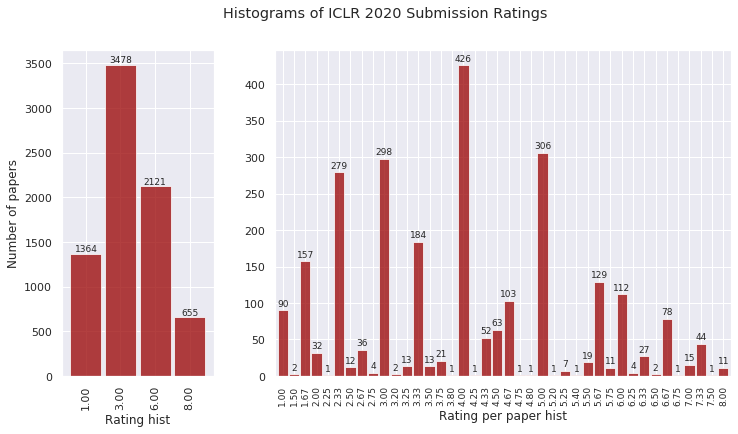

In [6]:
# Plot histograms of ratings
from collections import Counter
from matplotlib import gridspec
import seaborn as sns; sns.set()
fig = plt.figure(figsize=(12, 6))
plt.suptitle('Histograms of ICLR 2020 Submission Ratings')

# Rating hist
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
counterlist =  sorted(Counter(rating).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax1.set_xlabel('Rating hist')
ax1.set_ylabel('Number of papers')
ax1.set_xticklabels(x_labels)

rects = ax1.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=9)

# Rating per paper hist
plt.subplot(gs[1])
counterlist =  sorted(Counter(rating_mean).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax2 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax2.set_xlabel('Rating per paper hist')
ax2.set_xticklabels(x_labels, fontsize=9)

rects = ax2.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 3, label,
            ha='center', va='bottom', fontsize=9)
plt.show()
fig.savefig('asset/rating.png')

In [7]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating > np.array(rating_mean))/len(rating_mean)*100
    return pr
my_rating = (6+6+3)/3.  # your average rating here
print('Your papar ({:.2f}) beats {:.2f}% of submissions based on the ratings.'.format(
          my_rating, PR(rating_mean, my_rating)))

#            accept rate       orals     posters
# ICLR 2017: 39.1% (198/507)    15         183
# ICLR 2018: 32.0% (314/981)    23         291
# ICLR 2019: 31.4% (500/1591)   24         476
# ICLR 2020: ?     (?/2594)

Your papar (5.00) beats 69.97% of submissions based on the ratings.


In [8]:
# Count keywords
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
print('{} different keywords after merging'.format(len(keywords_hist)))

4124 different keywords before merging
3990 different keywords after merging


In [9]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

107


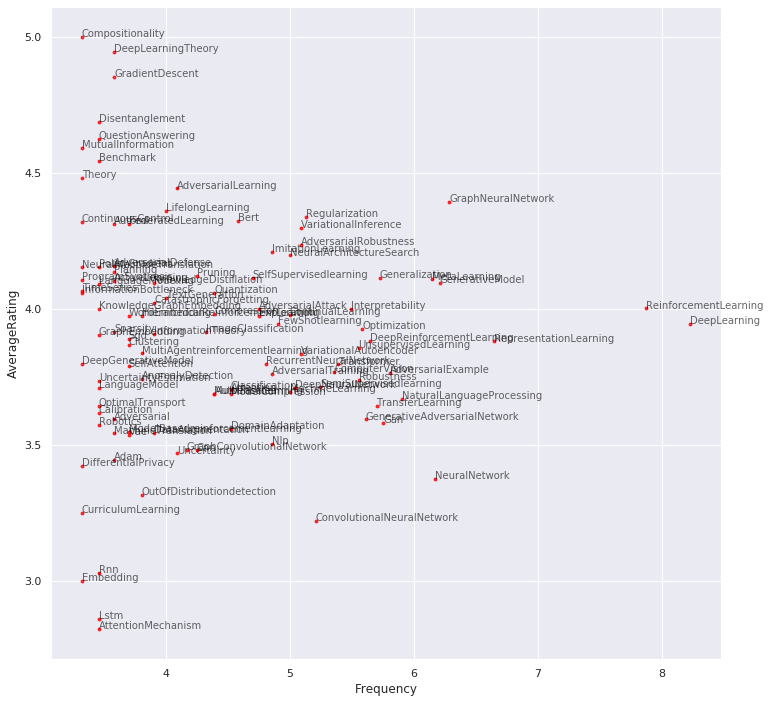

In [10]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
    'Frequency': x,
    'AverageRating': y,
    'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()
fig.savefig('asset/rating_frequency.png')

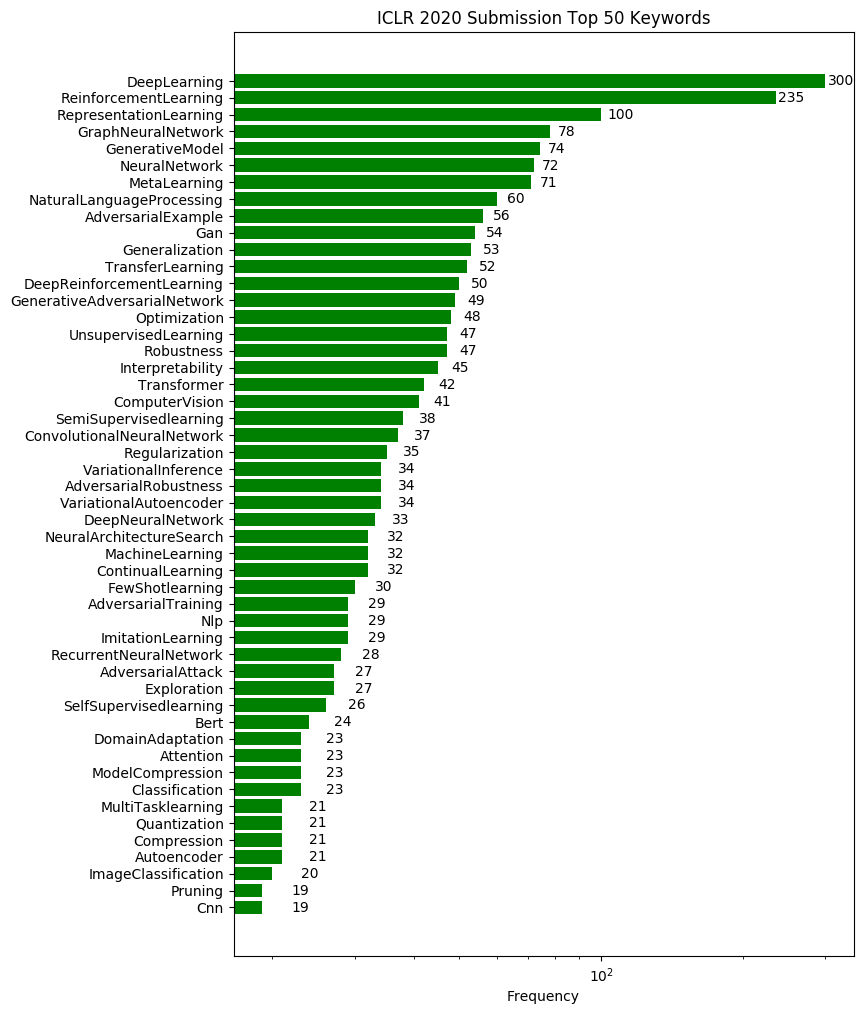

In [11]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2020 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()
fig.savefig('asset/frequency.png')

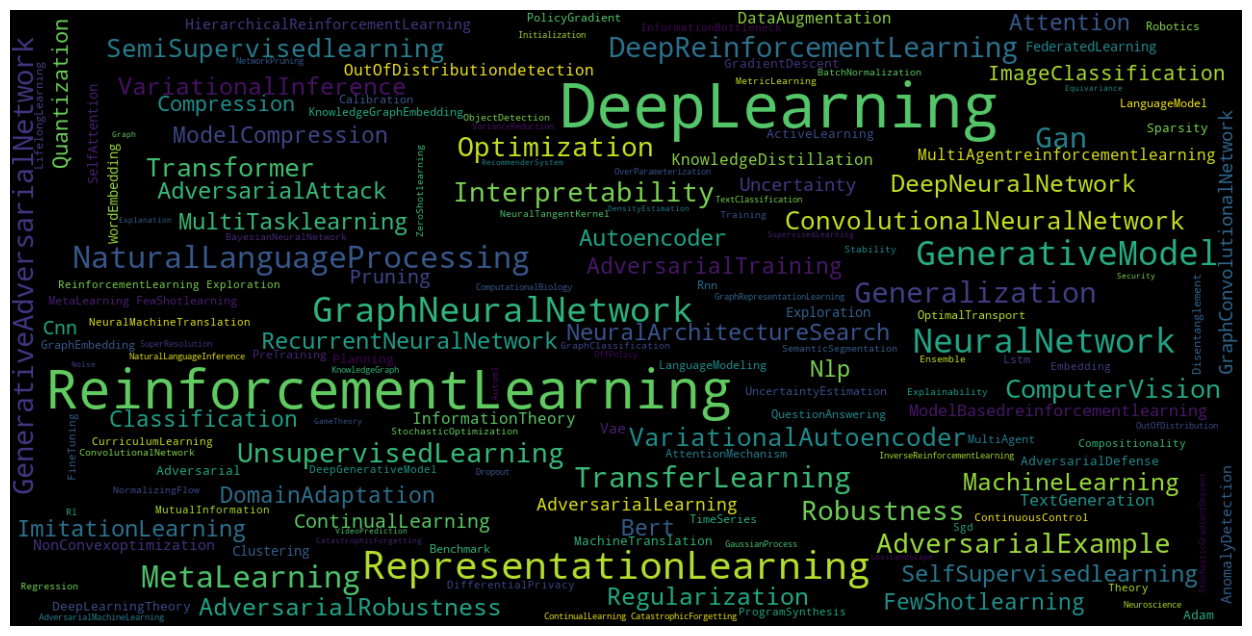

<Figure size 640x480 with 0 Axes>

In [12]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
fig = plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('asset/wordcloud.png')

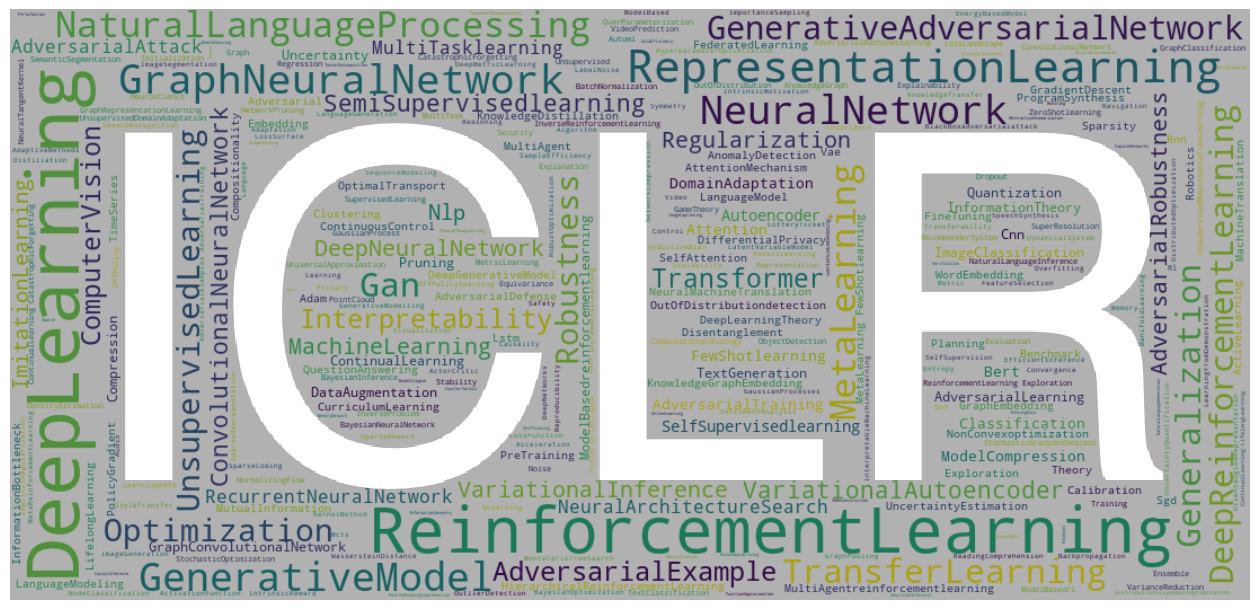

In [13]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('asset/logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
fig = plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()
fig.savefig('asset/logo_wordcloud.png')

In [14]:
num_valid = len(meta_list) - num_withdrawn
num_missing_rating = num_valid*3 - np.sum(np.clip(num_rating, 0, 3))
print('Number of missing reviews: {} ({:.4f}%)'.format(
    num_missing_rating, 100*float(num_missing_rating)/(num_valid*3)))

Number of missing reviews: 212 (2.7669%)


In [15]:
# the papers that don't have 3 reviews
for m in meta_list:
    if len(m.rating) < 3 and not (m.withdrawn or m.desk_reject):
        print(m.title, m.url, m.rating)

Learning Semantic Correspondences From Noisy Data-text Pairs By Local-to-global Alignments https://openreview.net/forum?id=Byx_GeSKPS [8 3]
On Weight-sharing And Bilevel Optimization In Architecture Search https://openreview.net/forum?id=HJgRCyHFDr [3 3]
Pretraining Boosts Out-of-domain Robustness For Pose Estimation https://openreview.net/forum?id=BkgMbCVFvr [1 1]
Exploiting Semantic Coherence To Improve Prediction In Satellite Scene Image Analysis: Application To Disease Density Estimation https://openreview.net/forum?id=Skxn-JSYwr [1 3]
The Dual Information Bottleneck https://openreview.net/forum?id=B1xZD1rtPr [3 6]
An Exponential Learning Rate Schedule For Batch Normalized Networks https://openreview.net/forum?id=rJg8TeSFDH [6 6]
A Theory Of Usable Information Under Computational Constraints https://openreview.net/forum?id=r1eBeyHFDH [8 8]
Understanding Knowledge Distillation In Non-autoregressive Machine Translation https://openreview.net/forum?id=BygFVAEKDH [3 6]
Retrospection: L

In [16]:
# high variance (both 1 and 8 but not 3 or 6)
for m in meta_list:
    if 1 in m.rating and 8 in m.rating and 6 not in m.rating and 3 not in m.rating:
        print(m.title, m.url, m.rating)        

Nas Evaluation Is Frustratingly Hard https://openreview.net/forum?id=HygrdpVKvr [8 8 1]
Robust Graph Representation Learning Via Neural Sparsification https://openreview.net/forum?id=S1emOTNKvS [8 1 1]
Varibad: A Very Good Method For Bayes-adaptive Deep Rl Via Meta-learning https://openreview.net/forum?id=Hkl9JlBYvr [1 8 1]
Active Learning Graph Neural Networks Via Node Feature Propagation https://openreview.net/forum?id=HylwpREtDr [8 1]
Instance Cross Entropy For Deep Metric Learning https://openreview.net/forum?id=BJeguTEKDB [8 1]
Nas-bench-1shot1: Benchmarking And Dissecting One-shot Neural Architecture Search https://openreview.net/forum?id=SJx9ngStPH [8 8 1]
Transferable Perturbations Of Deep Feature Distributions https://openreview.net/forum?id=rJxAo2VYwr [8 1 8]
Padé Activation Units: End-to-end Learning Of Flexible Activation Functions In Deep Networks https://openreview.net/forum?id=BJlBSkHtDS [1 8 1]
Accelerating Reinforcement Learning Through Gpu Atari Emulation https://open

In [17]:
# Write all the data to README
import datetime
with open('README.md', 'r+') as readme:
    lines = readme.readlines()

data_title = '## <a id="Data"></a>All ICLR 2020 OpenReview data\n'
idx = lines.index(data_title)
lines = lines[:idx]

with open('README.md', 'w') as readme:
    for line in lines:
        readme.write(line)
    readme.write(data_title)
    readme.write('Collected at {}\n\n'.format(datetime.datetime.now()))
    readme.write('Number of submissions: {} (withdrawn/desk reject submissions: {})\n\n'.format(
        len(meta_list), num_withdrawn))
    readme.write('| Rank | Average Rating | Title | Ratings | Variance | Decision |\n')
    readme.write('| --- | --- | --- | --- | --- | --- |\n')
    non_empty_rating_meta_list = [m for m in meta_list if not len(m.rating)==0]
    empty_rating_meta_list = [m for m in meta_list if len(m.rating)==0]    
    sorted_idx = np.argsort([np.mean(m.rating) for m in non_empty_rating_meta_list])[::-1]
    for i, idx in enumerate(sorted_idx):
        m = non_empty_rating_meta_list[idx]
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1, np.mean(m.rating), 
            m.title if not (m.withdrawn or m.desk_reject) else '~~'+m.title+'~~',  
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))
    for i, m in enumerate(empty_rating_meta_list):
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1+len(non_empty_rating_meta_list), np.mean(m.rating), 
            m.title if not (m.withdrawn or m.desk_reject) else '~~'+m.title+'~~',
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))

/home/walter/ENV/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/walter/ENV/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
if AFTER_DECISION:
    rating_mean_accept = []
    rating_mean_reject = []
    for m in meta_list:
        if len(m.rating) > 0:
            if 'Accept' in m.decision:
                rating_mean_accept.append(m.average_rating)
            else:
                rating_mean_reject.append(m.average_rating)
    print('Average rating of accepted papers: {}'.format(np.mean(rating_mean_accept)))
    print('Average rating of rejected papers: {}'.format(np.mean(rating_mean_reject)))

In [19]:
if AFTER_DECISION:
    fig = plt.figure(figsize=(12, 7))
    plt.title('Histograms of ICLR 2020 Submission Ratings', fontsize=15)

    # accepted
    counterlist_all = sorted(Counter(rating_mean).most_common())
    counterlist_accept =  sorted(Counter(rating_mean_accept).most_common())
    for c in counterlist_all:
        if c[0] not in [ca[0] for ca in counterlist_accept]:
            counterlist_accept.append((c[0], 0))
    counterlist_accept = sorted(counterlist_accept)
    frequencies = [k[1] for k in counterlist_accept]
    freq_series = pd.Series.from_array(frequencies)
    bins = [k[0] for k in counterlist_all]

    x_labels = ['{:.2f}'.format(b) for b in bins]

    ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.5, width=0.9)

    rects = ax1.patches
    labels = [int(frequencies[i]) for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        if label > 0:
            ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, label,
                     ha='center', va='bottom', fontsize=9, color='#990000')

    # rejected
    counterlist_reject =  sorted(Counter(rating_mean_reject).most_common())
    for c in counterlist_all:
        if c[0] not in [ca[0] for ca in counterlist_reject]:
            counterlist_reject.append((c[0], 0))
    counterlist_reject = sorted(counterlist_reject)
    frequencies = [k[1] for k in counterlist_reject]
    freq_series = pd.Series.from_array(frequencies)

    ax2 = freq_series.plot(kind='bar', color='#000099', alpha=0.5, width=0.9)
    ax2.set_xlabel('Rating per paper hist', fontsize=15)
    ax2.set_ylabel('Number of papers', fontsize=15)
    ax2.set_xticklabels(x_labels, fontsize=9)

    rects = ax2.patches[int(len(rects)/2):]
    labels = [int(frequencies[i]) for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        if label > 0:
            ax2.text(rect.get_x() + rect.get_width() / 2, height + 2, label,
                     ha='center', va='bottom', fontsize=9, color='#000099')

    ax1.legend(('Accepted Papers', 'Rejected Papers'), fontsize=15)
    plt.show()
    fig.savefig('asset/decision.png')